### Importing libraries

In [91]:
import openpyxl as op
import matplotlib.pyplot as plt
import timeit
import seaborn as sns
import numpy as np
import pandas as pd
from openpyxl import Workbook
import re
from IPython.display import set_matplotlib_formats
import collections
import plotly.graph_objects as go
import os
import glob
import plotly.express as px
import statistics

### Concatenate all hybrid alignment output tables

In [107]:
os.chdir("../B_hybrid_aln_results_toy/cblock-tables/")
extension = 'tsv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
print(all_filenames)

['alignment-analysis-chr1.tsv', 'alignment-analysis-chr19.tsv', 'alignment-analysis-chr22.tsv', 'alignment-analysis-chr12.tsv', 'alignment-analysis-chr13.tsv', 'alignment-analysis-chrX.tsv']


In [108]:
# writes a new excel file to the same directory
# out_path = r"../C_toy_plots/"
#writer = pd.ExcelWriter(out_path, engine='xlsxwriter')
writer = pd.ExcelWriter('merged_file.xlsx', engine='xlsxwriter')
for i, file in enumerate(all_filenames):
    df = pd.read_csv(file, sep="\t")
    df.to_excel(writer, sheet_name=str(all_filenames[i]))
writer.save()

### Create intermediate tables for plotting

In [134]:
# Load all files
wb = op.load_workbook(r'merged_file.xlsx')
xls = pd.ExcelFile('merged_file.xlsx')
writer = pd.ExcelWriter('intermediate.xlsx', engine='xlsxwriter')

sheet_count = len(xls.sheet_names)
append_data = []

for i in range(0, sheet_count):
    cols=[1,2,9,10,19,20]
    data = pd.read_excel(xls,i, usecols=cols)
    append_data.append(data)
    
append_data = pd.concat(append_data)   

append_data.to_excel(writer, sheet_name='Sheet1')
writer.save()
writer.close()

df = pd.read_excel('intermediate.xlsx')
df['Unnamed: 0'] = df['anchor']
df.columns = df.columns.str.replace('Unnamed: 0', 'gene')
df['gene'] = df.gene.str.extract('(.*?)-', expand=False)
df['s-pblock_subcat']=0
df.to_excel(r'intermediate.xlsx', index=False)

/usr/local/lib/python3.10/site-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [110]:
# Modify intermediate table
df = pd.read_excel('intermediate.xlsx')
df.head()
wb_i = op.load_workbook(r'intermediate.xlsx')
sheet_i=wb_i.active

c_rid =False
c_re=False
r=1

for i in range(2, sheet_i.max_row):
    c1_iso, c2_iso = sheet_i.cell(row=i, column=3), sheet_i.cell(row=i+1, column=3)
    c1_pb, c2_pb = sheet_i.cell(row=i, column=4), sheet_i.cell(row=i+1, column=4)
    c1_cb, c2_cb = sheet_i.cell(row=i, column=5), sheet_i.cell(row=i+1, column=5)
    if c1_iso.value == c2_iso.value:
        if c1_pb.value == c2_pb.value:
            #print(c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)
            if str(c1_cb.value).startswith("d") or str(c2_cb.value).startswith("d") or str(c1_cb.value).startswith("i") or str(c2_cb.value).startswith("i"):
                c_rid = True
            
            if str(c1_cb.value).startswith("e") or str(c2_cb.value).startswith("e"):
                c_re = True  
            r+=1

        else:
            if (c_rid == True and c_re == True):
                if str(c1_pb.value).startswith("S"):
                    #print(c1_pb.value, r)
                    for k in range(0, r):
                        sheet_i.cell(row=i-k, column=8).value = "ragged_S"
            c_rid =False
            c_re=False
            r=1

    else:
        if (c_rid == True and c_re == True):
            if str(c1_pb.value).startswith("S"):
                #print(c1_pb.value, r)
                for k in range(0, r):
                    sheet_i.cell(row=i-k, column=8).value = "ragged_S"



        c_rid =False
        c_re=False
        r=1
sheet_i.delete_cols(5)
wb_i.save('intermediate.xlsx')

In [142]:
# Load all files
wb = op.load_workbook(r'merged_file.xlsx')
xls = pd.ExcelFile('merged_file.xlsx')
writer = pd.ExcelWriter('intermediate_2.xlsx', engine='xlsxwriter')

sheet_count = len(xls.sheet_names)
append_data = []

for i in range(0, sheet_count):
    cols=[1,2,9]
    data = pd.read_excel(xls,i, usecols=cols)
    append_data.append(data) 
append_data = pd.concat(append_data)   

append_data.to_excel(writer, sheet_name='Sheet1')
writer.save()
writer.close()

df = pd.read_excel('intermediate_2.xlsx')
df['Unnamed: 0'] = df['anchor']
df.columns = df.columns.str.replace('Unnamed: 0', 'gene')
df['gene'] = df.gene.str.extract('(.*?)-', expand=False)
df.to_excel(r'intermediate_2.xlsx', index=False)

/usr/local/lib/python3.10/site-packages/xlsxwriter/workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


### Plot 1: Number of isoforms vs count of splice events affecting protein region plot
Plot how many protein regions (pblocks) are affected by splicing per isoform. 

In [145]:
wb = op.load_workbook(r'intermediate_2.xlsx')
sh = wb.active 

pb_stats = dict()
for x in range(1,51):
    pb_stats[x]=0

count = 1
for i in range(2, sh.max_row):
    # Alt isoform values for 2 cells to compare
    c1_iso, c2_iso = sh.cell(row=i, column=3), sh.cell(row=i+1, column=3)
    # Pblock values for 2 cells to compare
    c1_pb, c2_pb = sh.cell(row=i, column=4), sh.cell(row=i+1, column=4)
    
    # Both cells have same isoforms
    if c1_iso.value == c2_iso.value:
        # Have different pblocks
        if c1_pb.value != c2_pb.value:
            #print("Different pb for same iso ",c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)
            count+=1
            
    #When isoforms are different
    else:
        # # To get isoforms with extreme values
        if count == 0:
            print(c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)

        # Updating count
        pb_stats[count]+=1
        count=1

/var/folders/yj/q7ccjqsx2rg2czn92rx0_8sc0000gn/T/ipykernel_2152/405441406.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', quality=1200)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


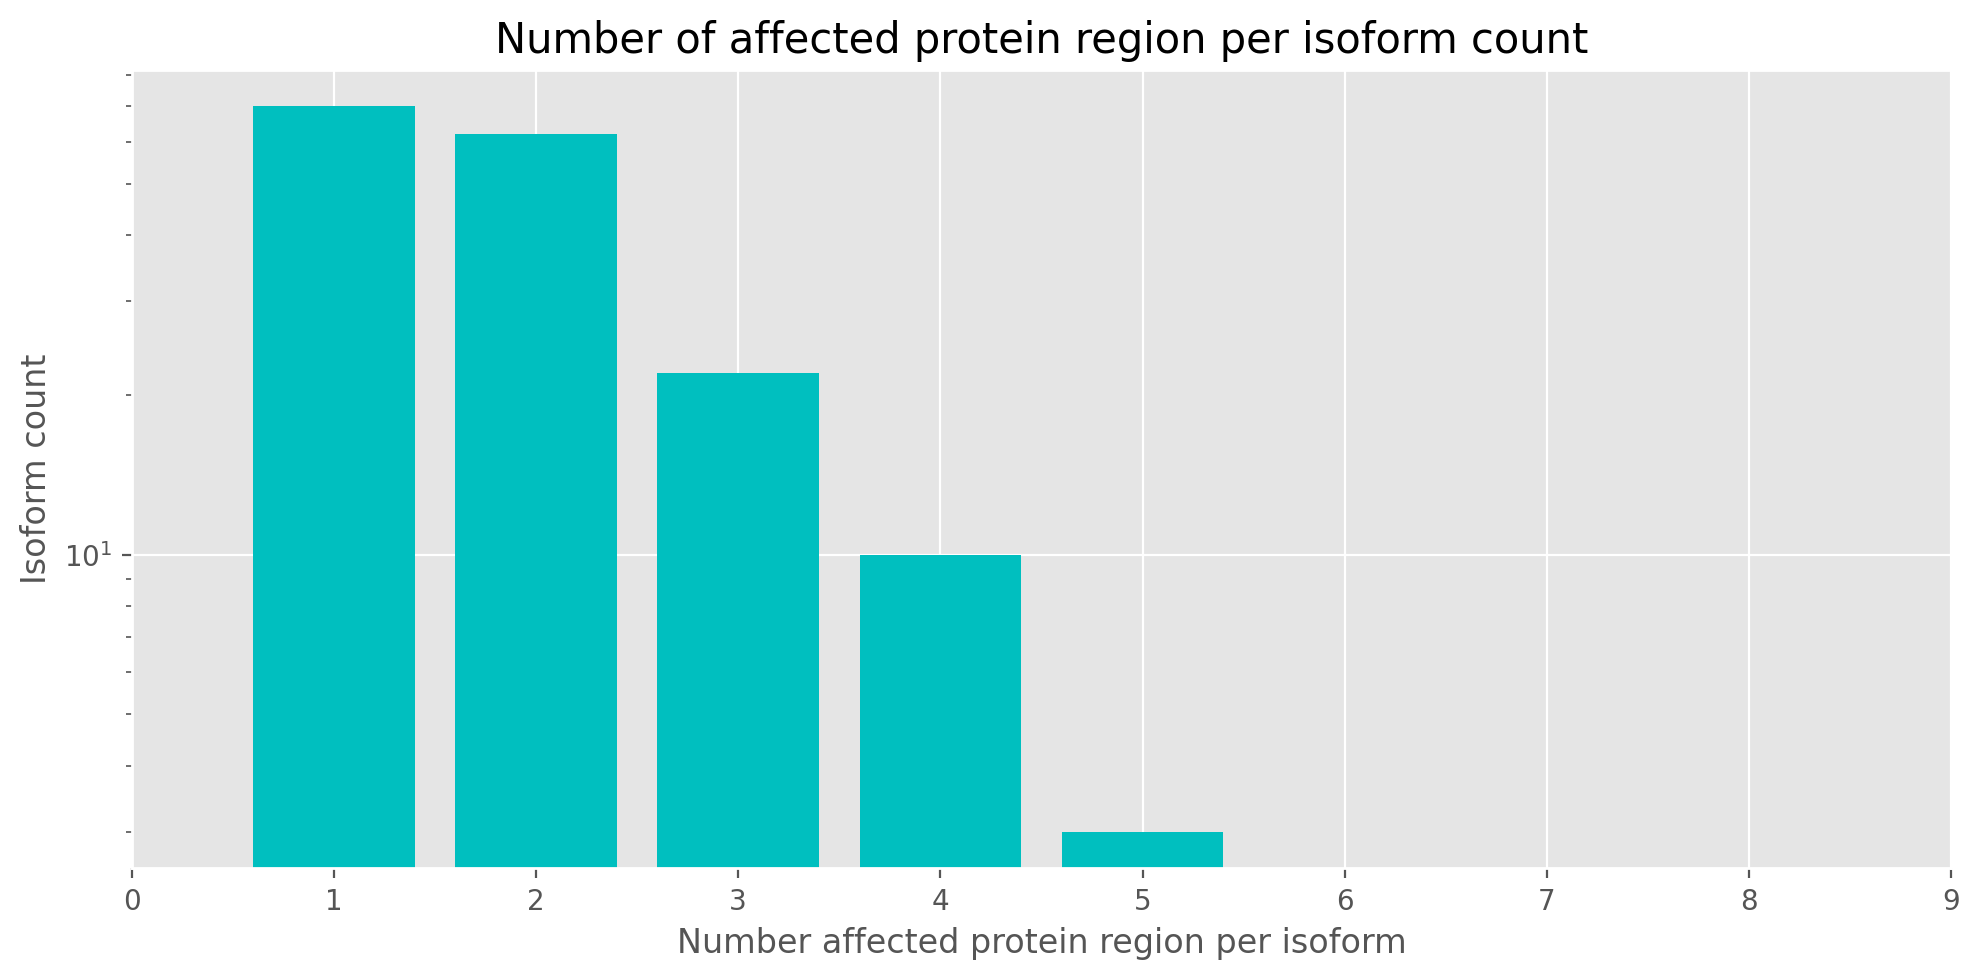

In [146]:
set_matplotlib_formats('retina', quality=1200)

plt.rcParams["figure.autolayout"] = True
plt.style.available
plt.style.use('ggplot')

plt.figure(figsize=(10,5))
plt.yscale('log')
plt.xlim(0, 9)
#plt.yticks([10 * i for i in range(11)])
# #avg line
# plt.axhline(mean_val, color='red', linestyle='dotted', linewidth=1)
plt.xlabel('Number affected protein region per isoform')
plt.ylabel('Isoform count')
plt.title('Number of affected protein region per isoform count', fontsize=15)
plt.bar(n_pb_stats.keys(), n_pb_stats.values(), width=0.8, color='c')
fig = plt.gcf()
fig.tight_layout()
plt.show()
#Saving figure
fig.savefig('../../C_toy_plots/isoform_pblock_count_histogram.png', dpi=1200)

### Plot 2: Size of affected protein regions vs number of isoform aggregate plot
To see what's the size of the pblocks being affected per isoform


In [155]:
wb = op.load_workbook(r'intermediate_2.xlsx')
sh = wb.active 
pb_stats_size = []

def getsize(c1_pb_val, sh, c1_iso_val):
    temp = re.findall(r'\d+', c1_pb_val)
    res = list(map(int, temp))
    size = res[1]-res[0]
    if  size == 0:
        size = res[3]-res[2]
    pb_stats_size.append(size)
    return 0


for i in range(2, sh.max_row):
    c1_ref, c2_ref = sh.cell(row=i, column=2), sh.cell(row=i+1, column=2)
    c1_iso, c2_iso = sh.cell(row=i, column=3), sh.cell(row=i+1, column=3)
    c1_pb, c2_pb = sh.cell(row=i, column=4), sh.cell(row=i+1, column=4)

    # When iso are same
    if c1_iso.value == c2_iso.value:
        if c1_pb.value != c2_pb.value:
            getsize(c1_pb.value, sh, c1_iso.value)
    #When iso are different
    else: 
        getsize(c1_pb.value, sh, c1_iso.value)

counter = collections.Counter(pb_stats_size)
#counter=sorted(counter.items())

#print(counter)
x1 = list(counter.keys())
y1 = list(counter.values())

average_size = sum(pb_stats_size)/len(pb_stats_size)
print(average_size)
print(statistics.median(pb_stats_size))


152.40952380952382
50


/var/folders/yj/q7ccjqsx2rg2czn92rx0_8sc0000gn/T/ipykernel_2152/4265961428.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', quality=1200)


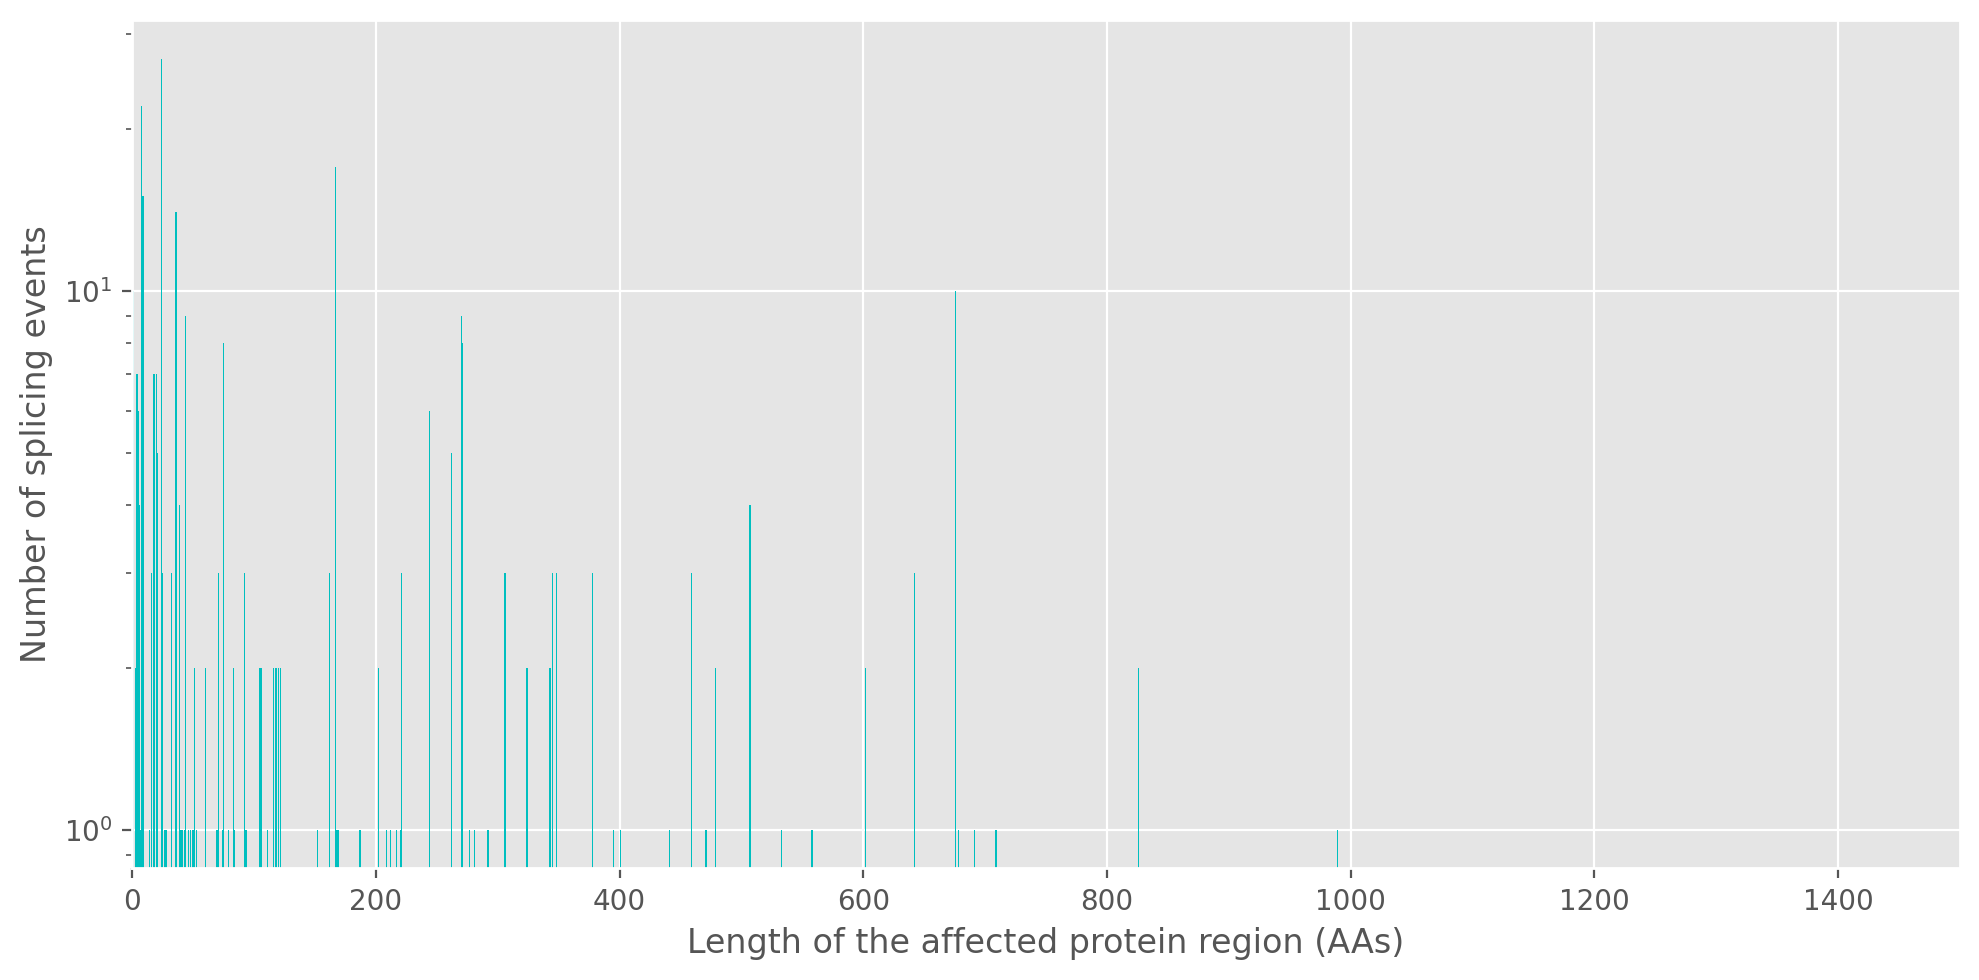

In [156]:
set_matplotlib_formats('retina', quality=1200)
plt.rcParams["figure.autolayout"] = True
plt.style.available
#plt.style.use('ggplot')


plt.figure(figsize=(10,5))
plt.yscale('log')
plt.xlim(0,1500)
#plt.yticks([10 * i for i in range(11)])
# #avg line
# plt.axhline(mean_val, color='red', linestyle='dotted', linewidth=1)
plt.xlabel('Length of the affected protein region (AAs)')
plt.ylabel('Number of splicing events')
#plt.title('Number of affected protein region per isoform count', fontsize=15)
plt.bar(x1, y1, width=1, color='c')
fig = plt.gcf()
fig.tight_layout()
plt.show()

#Saving figure
fig.savefig('../../C_toy_plots/isoform_pblock_size_histogram.png', dpi=1200)

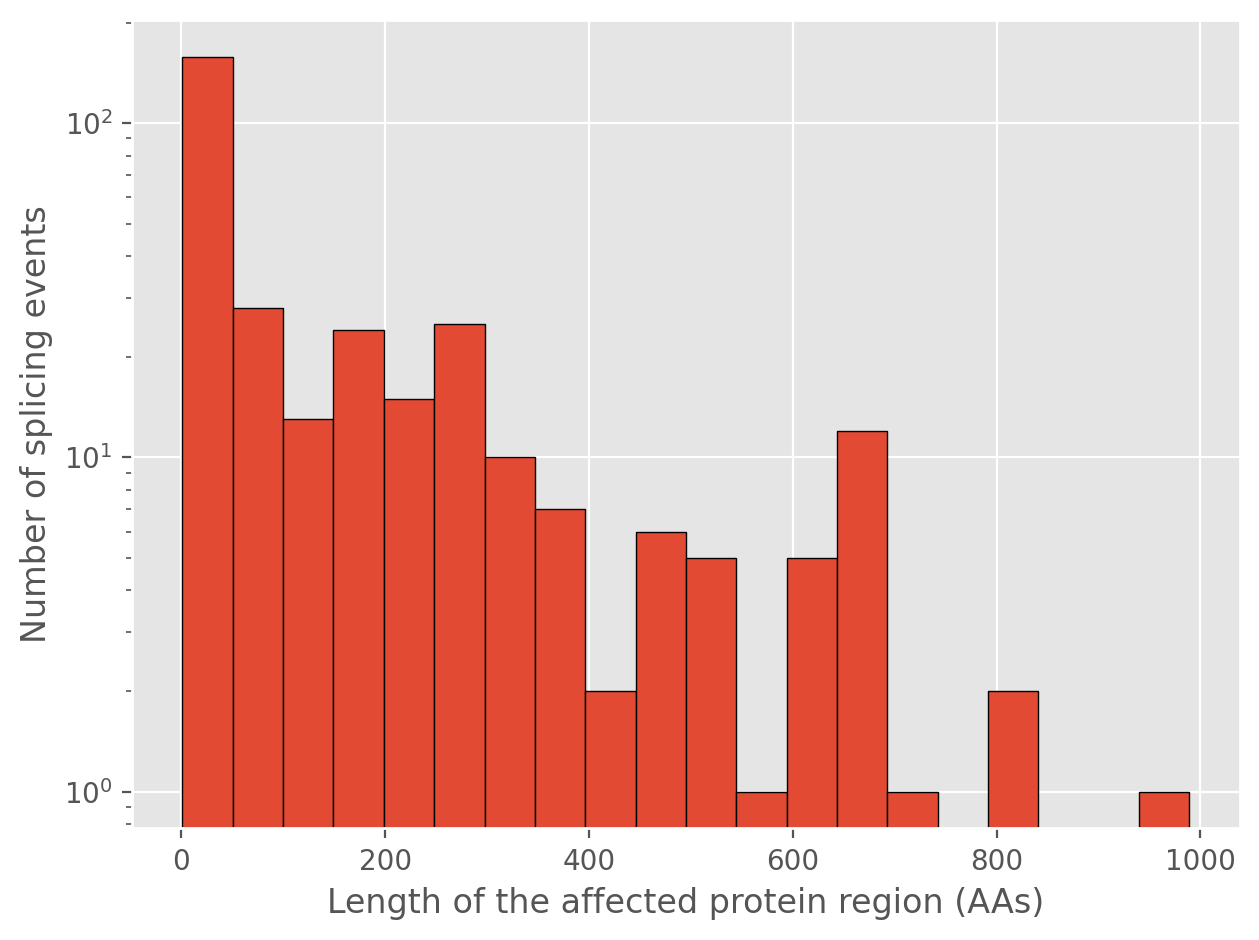

In [154]:
plt.hist(pb_stats_size, bins=20, edgecolor='black')
plt.xlabel('Length of the affected protein region (AAs)')
plt.ylabel('Number of splicing events')
plt.yscale('log')
plt.show()

### Plot 3: Size of affected protein regions vs number of isoform aggregate plot for Insertion splicing event
To see what's the size of the pblocks being affected per isoform


In [163]:
wb = op.load_workbook(r'intermediate_2.xlsx')
sh = wb.active 
pb_stats_size_I=[]


def getsize(c1_pb_val, sh, c1_iso_val):
    temp = re.findall(r'\d+', c1_pb_val)
    res = list(map(int, temp))
    size = res[1]-res[0]
    if  size == 0:
        size = res[3]-res[2]
    if c1_pb_val.startswith("I"):
        pb_stats_size_I.append(size)
    return 0


for i in range(2, sh.max_row):
    c1_ref, c2_ref = sh.cell(row=i, column=2), sh.cell(row=i+1, column=2)
    c1_iso, c2_iso = sh.cell(row=i, column=3), sh.cell(row=i+1, column=3)
    c1_pb, c2_pb = sh.cell(row=i, column=4), sh.cell(row=i+1, column=4)

    # When iso are same
    if c1_iso.value == c2_iso.value:
        if c1_pb.value != c2_pb.value:
            #pblock is different for the iso
            getsize(c1_pb.value, sh, c1_iso.value)

    #When iso are different
    else: 
        getsize(c1_pb.value, sh, c1_iso.value)
            
counter = collections.Counter(pb_stats_size_I)
#print(counter)
xi = list(counter.keys())
yi = list(counter.values())

/var/folders/yj/q7ccjqsx2rg2czn92rx0_8sc0000gn/T/ipykernel_2152/2374048952.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', quality=1200)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


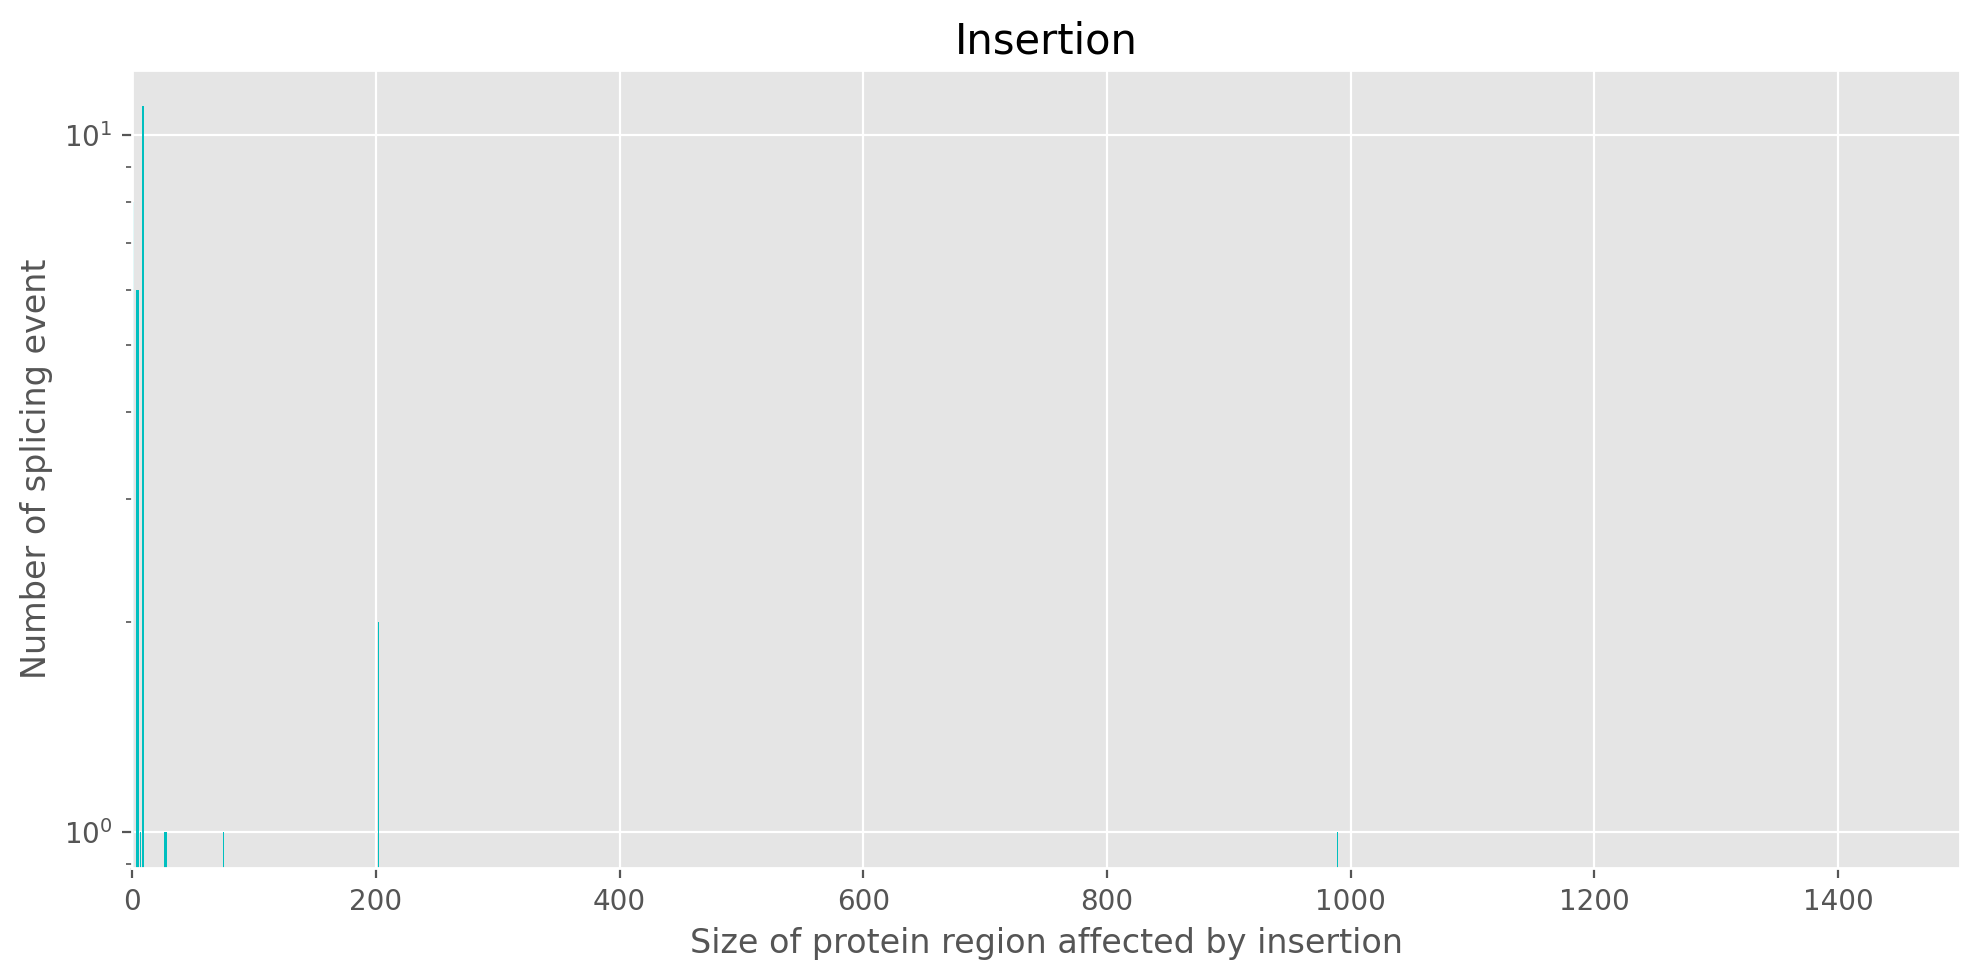

In [164]:
set_matplotlib_formats('retina', quality=1200)
plt.rcParams["figure.autolayout"] = True
plt.style.available
plt.style.use('ggplot')

plt.figure(figsize=(10,5))
plt.yscale('log')
plt.xlim(0,1500)
#plt.yticks([10 * i for i in range(11)])
# #avg line
# plt.axhline(mean_val, color='red', linestyle='dotted', linewidth=1)
plt.title("Insertion", fontsize=15)
plt.xlabel('Size of protein region affected by insertion')
plt.ylabel('Number of splicing event')

plt.bar(xi, yi, width=1, color='c')
fig = plt.gcf()
fig.tight_layout()
plt.show()

#Saving figure
fig.savefig('../../C_toy_plots/isoform_pblock_size_histogram_I.png', dpi=1200)


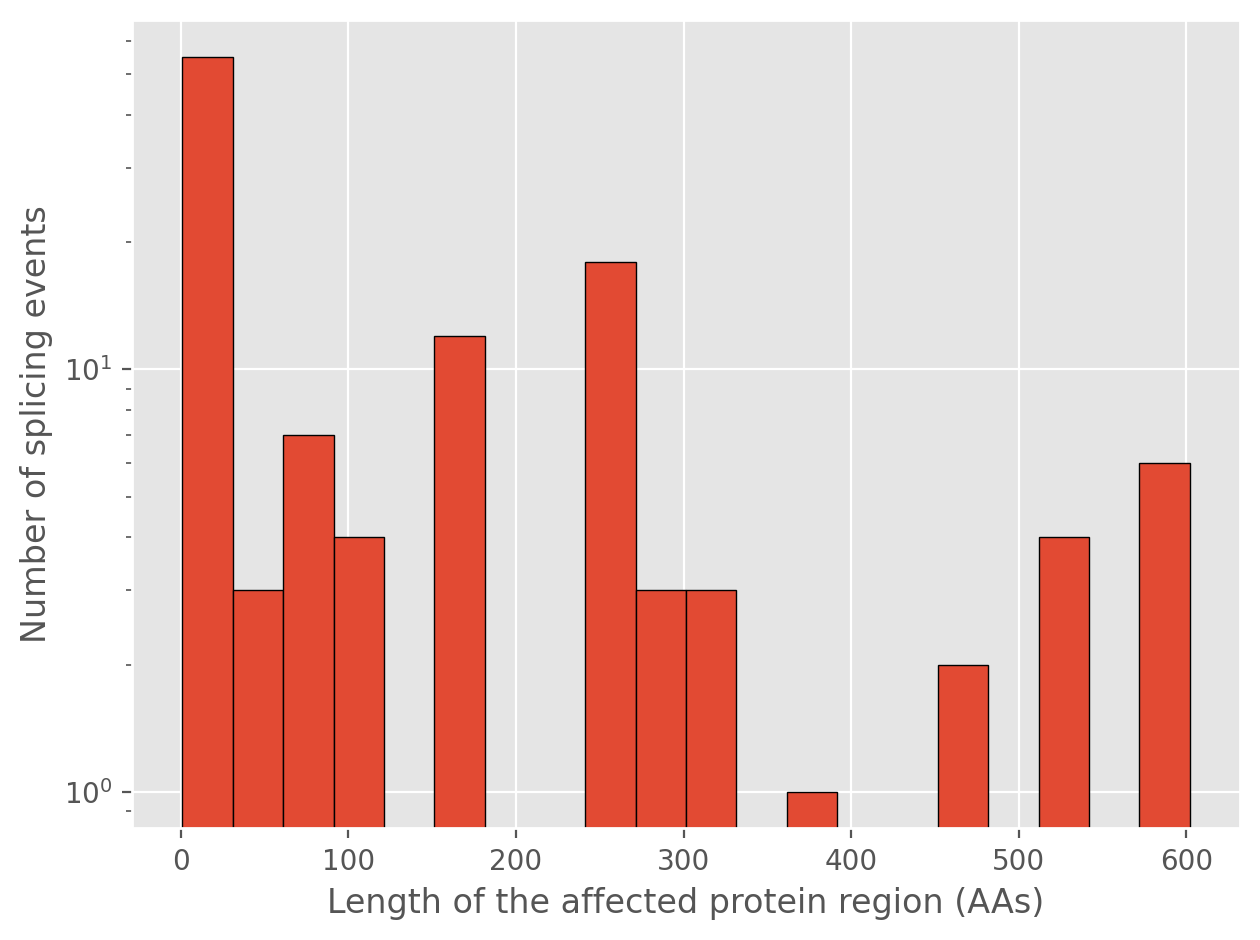

In [165]:
plt.hist(pb_stats_size_D, bins=20, edgecolor='black')
plt.xlabel('Length of the affected protein region (AAs)')
plt.ylabel('Number of splicing events')
plt.yscale('log')
plt.show()

### Plot 4: Size of affected protein regions vs number of isoform aggregate plot for deletion splice event
To see what's the size of the pblocks being affected per isoform


In [166]:
wb = op.load_workbook(r'intermediate_2.xlsx')
sh = wb.active 
pb_stats_size_D=[]

def getsize(c1_pb_val, sh, c1_iso_val):
    temp = re.findall(r'\d+', c1_pb_val)
    res = list(map(int, temp))
    size = res[1]-res[0]
    if  size == 0:
        size = res[3]-res[2]
    elif c1_pb_val.startswith("D"):
        pb_stats_size_D.append(size)
    return 0


for i in range(2, sh.max_row):
    c1_ref, c2_ref = sh.cell(row=i, column=2), sh.cell(row=i+1, column=2)
    c1_iso, c2_iso = sh.cell(row=i, column=3), sh.cell(row=i+1, column=3)
    c1_pb, c2_pb = sh.cell(row=i, column=4), sh.cell(row=i+1, column=4)

    # When iso are same
    if c1_iso.value == c2_iso.value:
        if c1_pb.value != c2_pb.value:
            #pblock is different for the iso
            getsize(c1_pb.value, sh, c1_iso.value)
    # when iso are different
    else: 
        getsize(c1_pb.value, sh, c1_iso.value)
            
counter = collections.Counter(pb_stats_size_D)
#print(counter)
xd = list(counter.keys())
yd = list(counter.values())

/var/folders/yj/q7ccjqsx2rg2czn92rx0_8sc0000gn/T/ipykernel_2152/1316607951.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', quality=1200)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


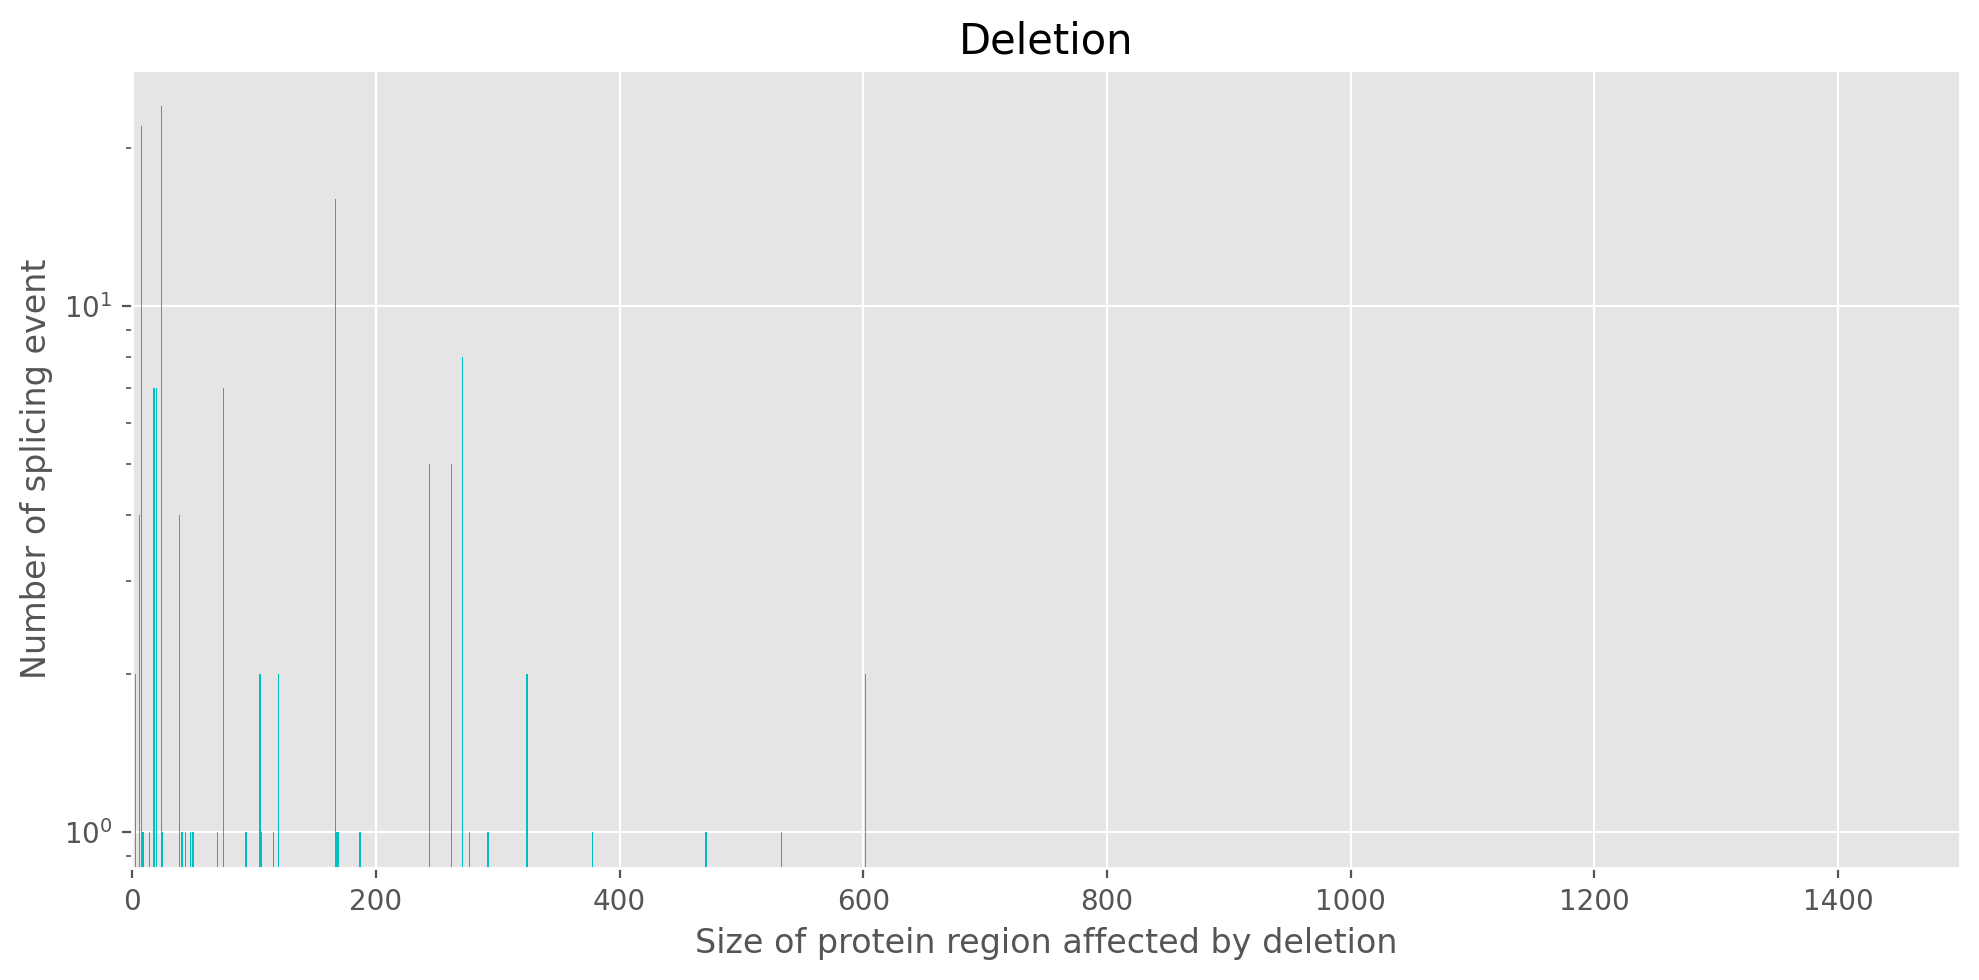

In [167]:

set_matplotlib_formats('retina', quality=1200)
plt.rcParams["figure.autolayout"] = True
plt.style.available
plt.style.use('ggplot')

plt.figure(figsize=(10,5))
plt.yscale('log')
plt.xlim(0,1500)
#plt.yticks([10 * i for i in range(11)])
# #avg line
# plt.axhline(mean_val, color='red', linestyle='dotted', linewidth=1)
plt.title("Deletion", fontsize=15)
plt.xlabel('Size of protein region affected by deletion')
plt.ylabel('Number of splicing event')

plt.bar(xd, yd, width=1, color='c')
fig = plt.gcf()
fig.tight_layout()
plt.show()

#Saving figure
fig.savefig('../../C_toy_plots/isoform_pblock_size_histogram_D.png', dpi=1200)


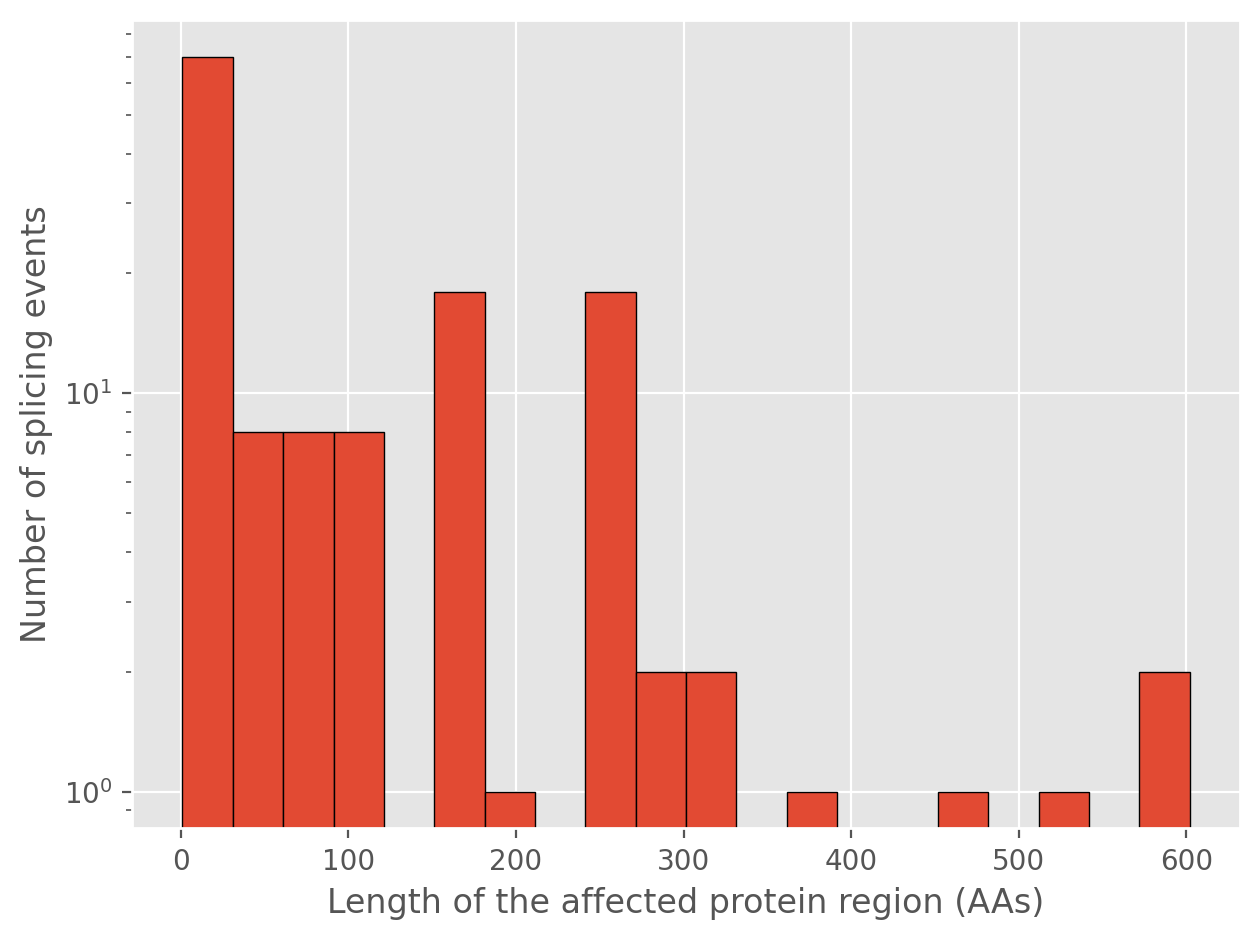

In [168]:
plt.hist(pb_stats_size_D, bins=20, edgecolor='black')
plt.xlabel('Length of the affected protein region (AAs)')
plt.ylabel('Number of splicing events')
plt.yscale('log')
plt.show()

### Plot 5: Size of affected protein regions vs number of isoform aggregate plot for substitution splice event
To see what's the size of the pblocks being affected per isoform


In [169]:
wb = op.load_workbook(r'intermediate_2.xlsx')
sh = wb.active 
pb_stats_size_S=[]

def getsize(c1_pb_val, sh, c1_iso_val):
    temp = re.findall(r'\d+', c1_pb_val)
    res = list(map(int, temp))
    size = res[1]-res[0]
    if  size == 0:
        size = res[3]-res[2]

    elif c1_pb_val.startswith("S"):
        pb_stats_size_S.append(size)

    return 0

for i in range(2, sh.max_row):
    c1_ref, c2_ref = sh.cell(row=i, column=2), sh.cell(row=i+1, column=2)
    c1_iso, c2_iso = sh.cell(row=i, column=3), sh.cell(row=i+1, column=3)
    c1_pb, c2_pb = sh.cell(row=i, column=4), sh.cell(row=i+1, column=4)

    # When iso are same
    if c1_iso.value == c2_iso.value:
        if c1_pb.value != c2_pb.value:
            getsize(c1_pb.value, sh, c1_iso.value)
   

    #When iso are different
    else: 
        getsize(c1_pb.value, sh, c1_iso.value)

counter = collections.Counter(pb_stats_size_S)
#print(counter)
xs = list(counter.keys())
ys = list(counter.values())


/var/folders/yj/q7ccjqsx2rg2czn92rx0_8sc0000gn/T/ipykernel_2152/3125397154.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', quality=1200)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


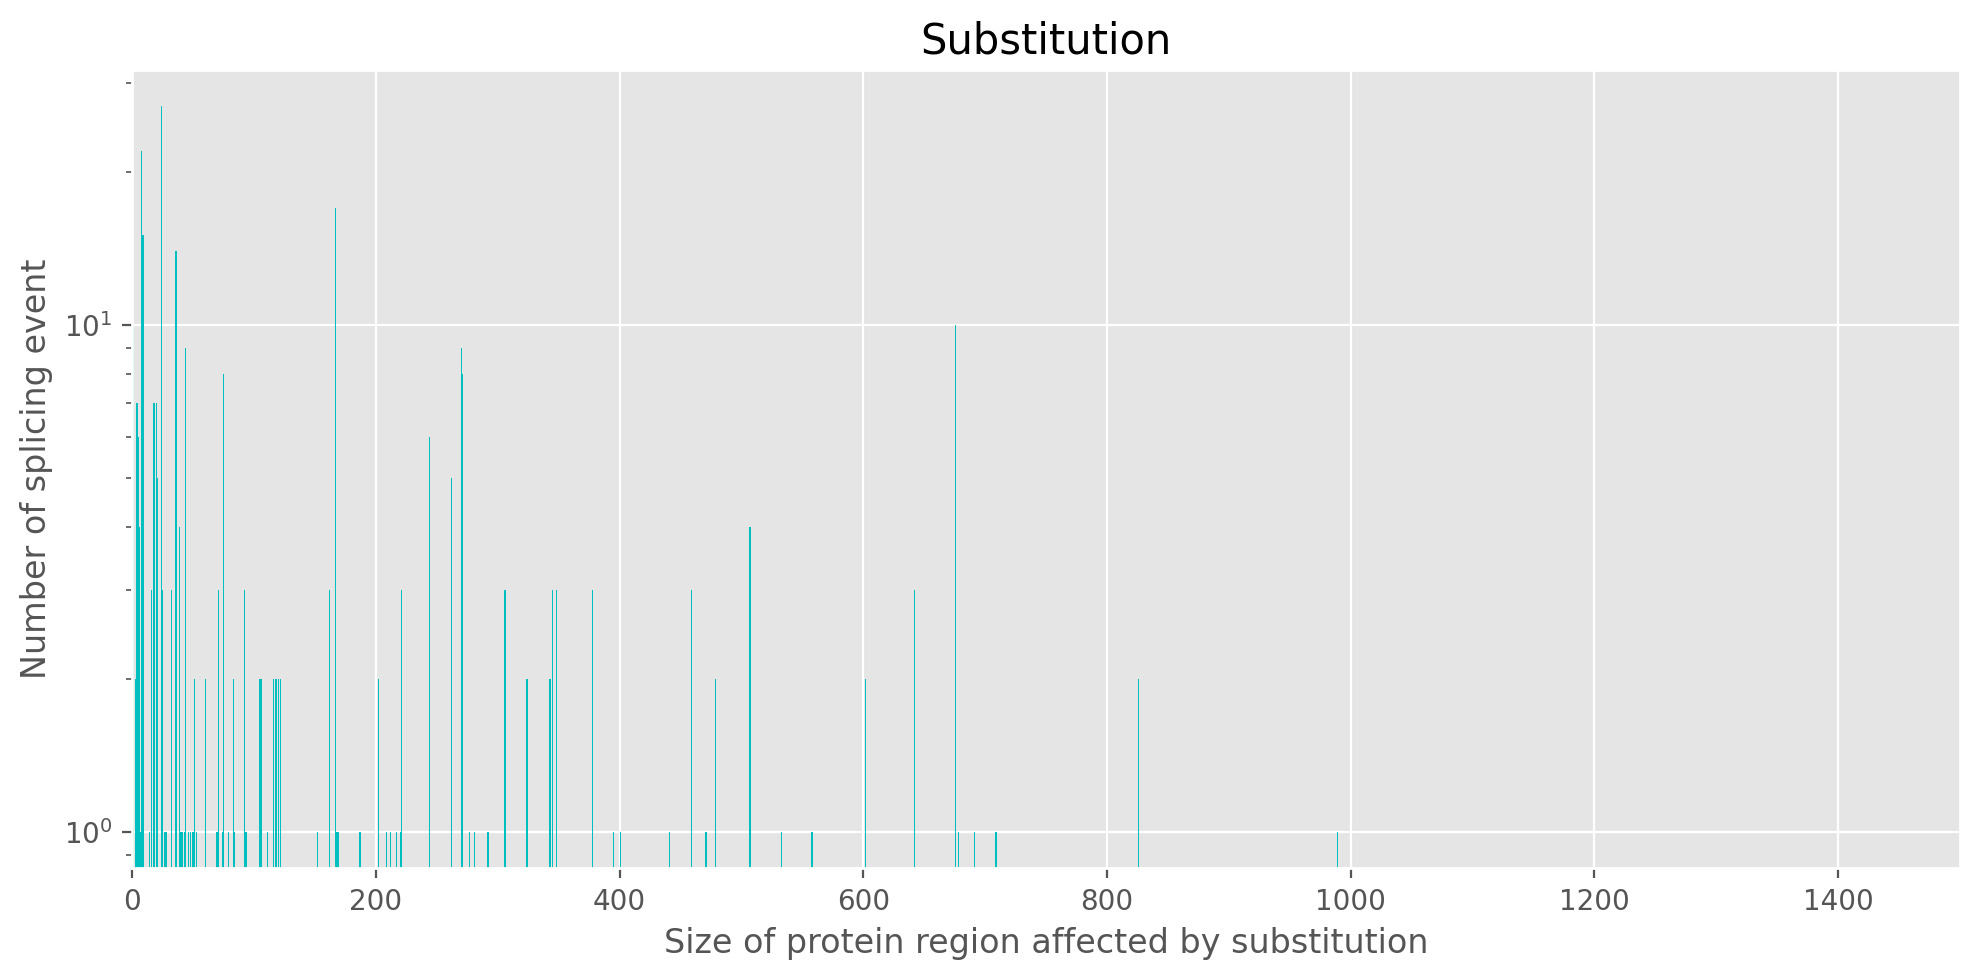

In [170]:

set_matplotlib_formats('retina', quality=1200)
plt.rcParams["figure.autolayout"] = True
plt.style.available
plt.style.use('ggplot')


plt.figure(figsize=(10,5))
plt.yscale('log')
plt.xlim(0,1500)
#plt.yticks([10 * i for i in range(11)])
# #avg line
# plt.axhline(mean_val, color='red', linestyle='dotted', linewidth=1)
plt.title("Substitution", fontsize=15)
plt.xlabel('Size of protein region affected by substitution')
plt.ylabel('Number of splicing event')

plt.bar(x1, y1, width=1, color='c')
fig = plt.gcf()
fig.tight_layout()
plt.show()

#Saving figure
fig.savefig('../../C_toy_plots/isoform_pblock_size_histogram_S.png',dpi=1200)

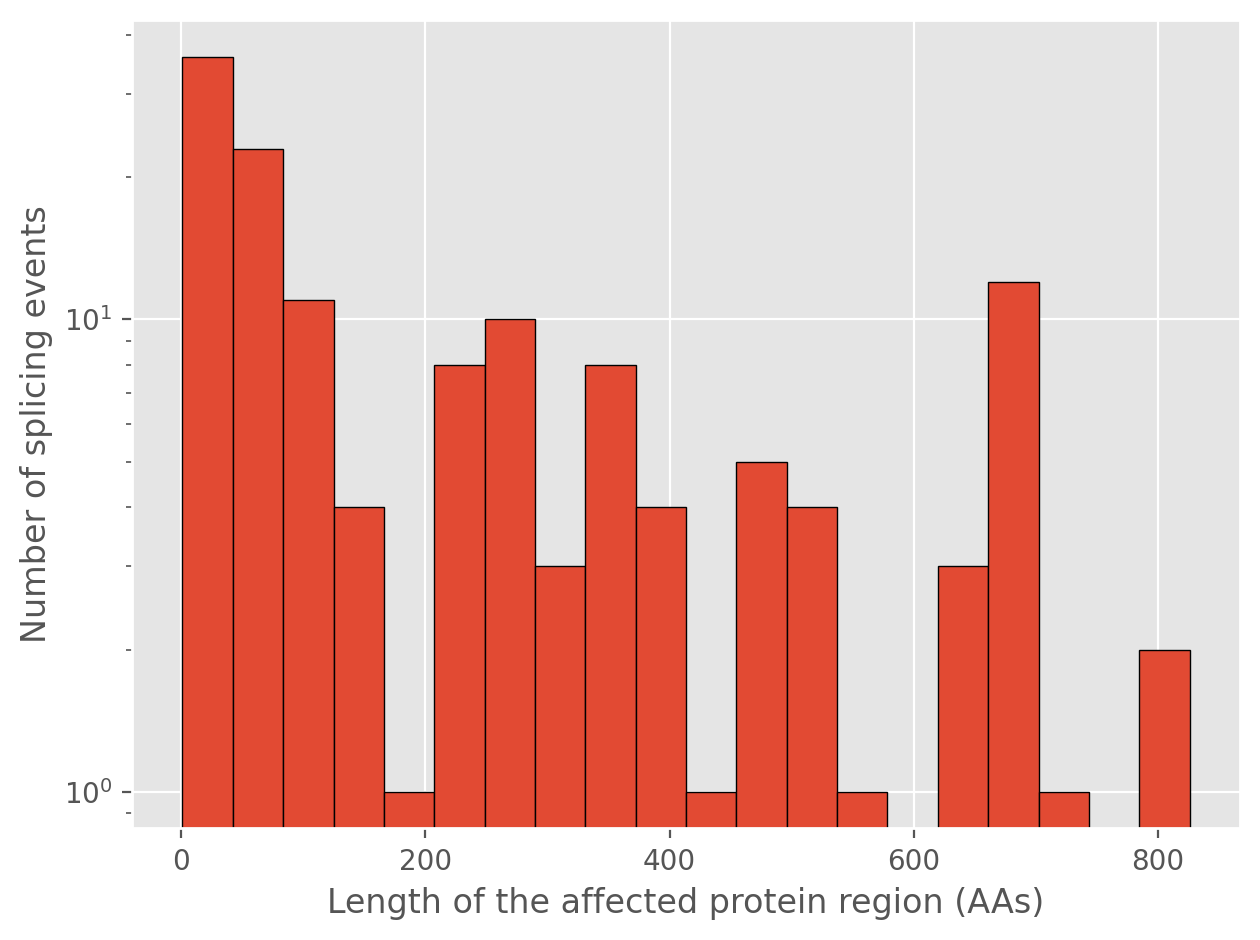

In [171]:
plt.hist(pb_stats_size_S, bins=20, edgecolor='black')
plt.xlabel('Length of the affected protein region (AAs)')
plt.ylabel('Number of splicing events')
plt.yscale('log')
plt.show()

### Plot 6: Number of isoforms vs count of splice events affecting protein region plot for ragged and clean I/D/S

In [174]:
wb = op.load_workbook(r'intermediate_2.xlsx')
sh = wb.active 

ref_s=[]
alt_s=[]

def getsize(c1_pb_val):
    temp = re.findall(r'\d+', c1_pb_val)
    res = list(map(int, temp))
    size_ref = res[1]-res[0]
    size_alt = res[3]-res[2]
    ref_s.append(size_ref)
    alt_s.append(size_alt)
    return 0

for sh in wb.worksheets:
    for i in range(2, sh.max_row):
        c1_pb = sh.cell(row=i, column=4)
        c2_pb = sh.cell(row=i+1, column=4)
            
        if c1_pb.value != c2_pb.value:
            if c1_pb.value.startswith("S"):
                getsize(c1_pb.value)
        

/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


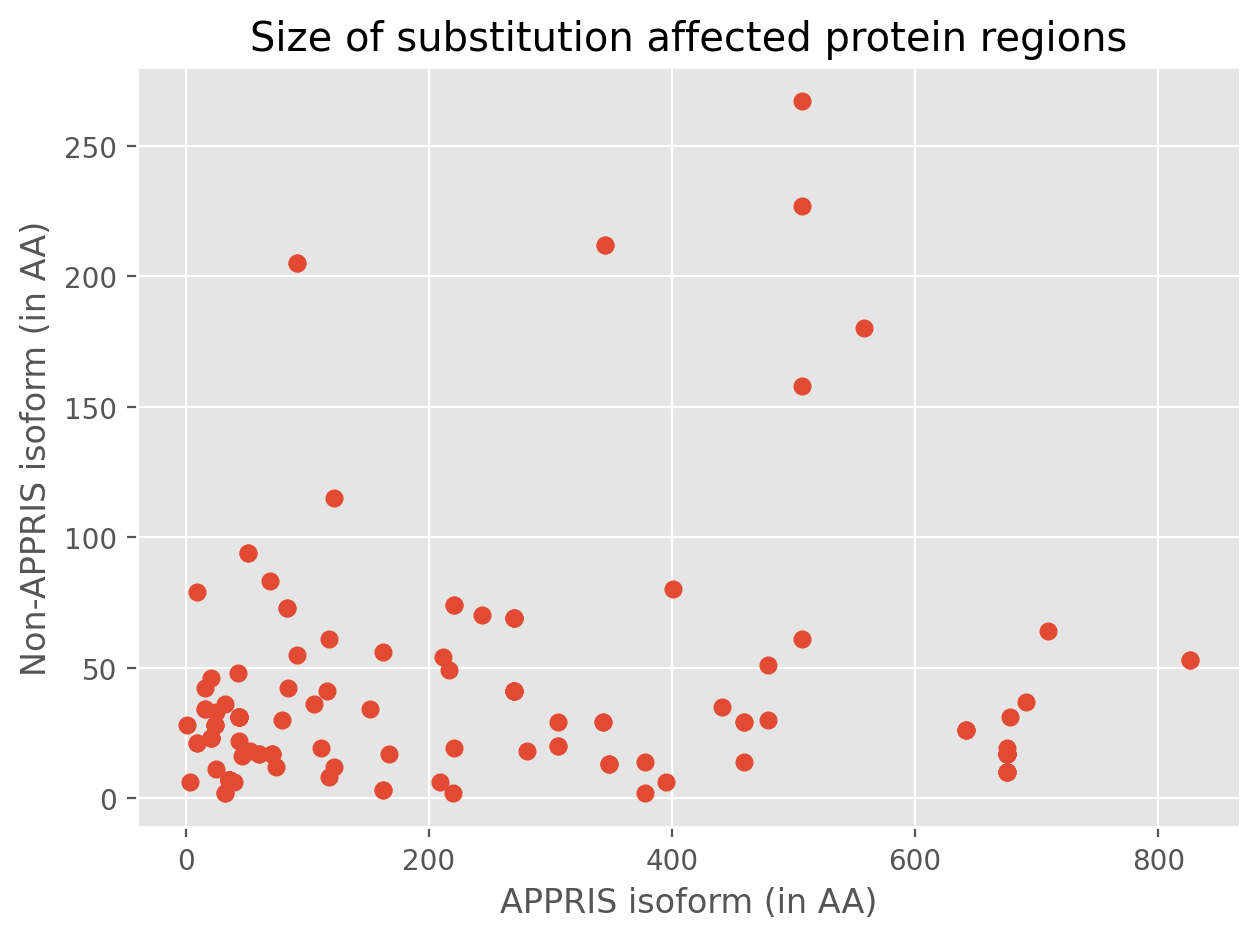

In [175]:
plt.style.use('ggplot')
plt.scatter(ref_s,alt_s)
plt.xlabel('APPRIS isoform (in AA)')
plt.ylabel('Non-APPRIS isoform (in AA)')
plt.title('Size of substitution affected protein regions')

plt.show()
#Saving figure
fig.savefig('../../C_toy_plots/isoform_substitution_categories.png',dpi=1200)